# Figure 1 - Yeast GI Profile Similarity Matrix

Post hoc enrichment-based annotation of a hierarchically clustered _Saccharomyces cerevisiae_ genetic interaction (GI) profile similarity matrix.

In [1]:
# Enable inline plotting for notebooks
%matplotlib inline

In [2]:
# Figure export directory for HiMaLAYAS outputs.
from pathlib import Path

PNG_DIR = Path("png") / "fig_1"
PNG_DIR.mkdir(parents=True, exist_ok=True)

## Load Inputs

Load GO BP annotations and the GI PCC matrix used for clustering and enrichment.

GO BP terms loaded: 1,095
Min term size: 5
Max term size: 243
Unique ORFs across all terms: 4,927


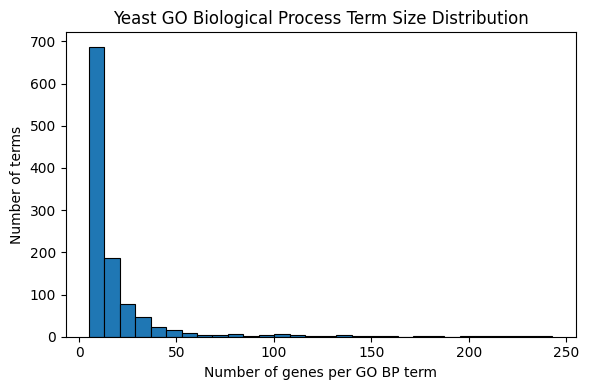

In [3]:
# Loads pre-filtered GO BP annotations and visualizes term sizes.
import json

import matplotlib.pyplot as plt

DATA_DIR = Path("data/yeast")
GO_BP_PATH = DATA_DIR / "go_bp_name_to_orfs.json"

# Load GO Biological Process term -> ORF mapping (already filtered upstream)
with GO_BP_PATH.open("r", encoding="utf-8") as fh:
    go_bp = json.load(fh)

# Compute term sizes and global ORF coverage
term_sizes = [len(set(orfs)) for orfs in go_bp.values()]
all_orfs = {orf for orfs in go_bp.values() for orf in orfs}

# Summary statistics reported in the manuscript
print(f"GO BP terms loaded: {len(term_sizes):,}")
print(f"Min term size: {min(term_sizes)}")
print(f"Max term size: {max(term_sizes)}")
print(f"Unique ORFs across all terms: {len(all_orfs):,}")

# Histogram of GO BP term sizes
plt.figure(figsize=(6, 4))
plt.hist(
    term_sizes,
    bins=30,
    edgecolor="black",
    linewidth=0.8,
)
plt.xlabel("Number of genes per GO BP term")
plt.ylabel("Number of terms")
plt.title("Yeast GO Biological Process Term Size Distribution")
plt.tight_layout()
plt.show()

In [4]:
import pandas as pd

MATRIX_PATH = DATA_DIR / "gi_pcc_sampled.tsv"

# Load GI PCC matrix (ORF x ORF)
DF_GI_PCC = pd.read_csv(
    MATRIX_PATH,
    sep="\t",
    index_col=0,
)

# Sanity checks
print(f"Matrix shape: {DF_GI_PCC.shape[0]:,} × {DF_GI_PCC.shape[1]:,}")
print(f"Row/column labels identical: {DF_GI_PCC.index.equals(DF_GI_PCC.columns)}")
print(f"Value range: [{DF_GI_PCC.min().min():.3f}, {DF_GI_PCC.max().max():.3f}]")

display(DF_GI_PCC.head())

Matrix shape: 1,053 × 1,053
Row/column labels identical: True
Value range: [-0.317, 0.845]


,YLR088W,YBR004C,YAR007C,YDL145C,YNL041C,YOR336W,YDR331W,YHR188C,YFL038C,YNL051W,...,YML124C,YLR113W,YJR108W,YJL029C,YPR114W,YGL051W,YGL110C,YMR227C,YGR243W,YKL113C
YLR088W,0.000,0.368,-0.114,0.269,0.108,0.513,0.5195,0.672,0.105,0.177,...,-0.076,0.006,0.051,0.000,-0.044,0.019,0.152,0.090,0.000,-0.111
YBR004C,0.368,0.000,-0.151,0.252,0.254,0.483,0.3445,0.453,0.216,0.236,...,-0.101,0.116,-0.026,0.000,-0.089,-0.076,0.060,0.150,0.000,-0.090
YAR007C,-0.114,-0.151,0.000,-0.177,-0.250,-0.220,-0.1685,-0.165,-0.232,-0.221,...,-0.042,0.076,-0.062,0.000,-0.043,-0.004,-0.041,-0.100,0.000,0.218
YDL145C,0.269,0.252,-0.177,0.002,0.454,0.224,0.3715,0.307,0.422,0.440,...,-0.056,0.024,0.031,0.193,-0.001,-0.015,0.083,0.000,-0.004,-0.088
YNL041C,0.108,0.254,-0.250,0.454,0.002,0.148,0.2290,0.187,0.523,0.788,...,-0.010,0.047,0.038,0.180,0.006,-0.046,0.088,-0.012,-0.033,-0.060


## Cluster, Enrich, and Filter

Run hierarchical clustering, evaluate enrichment across dendrogram-defined clusters, and filter by Benjamini-Hochberg FDR (`qval <= 0.05`).

In [5]:
from himalayas import Analysis, Annotations, Matrix

LINKAGE_THRESHOLD = 16

# Build core objects
matrix = Matrix(DF_GI_PCC)
annotations = Annotations(
    go_bp,
    matrix,
)

# Run clustering + enrichment
analysis = (
    Analysis(matrix, annotations)
    .cluster(
        linkage_method="ward",
        linkage_metric="euclidean",
        linkage_threshold=LINKAGE_THRESHOLD,
        min_cluster_size=30,
    )
    .enrich(min_overlap=2)
    .finalize(
        col_cluster=True,
        add_qvalues=True,
    )
)
results = analysis.results
# Keep significant terms
results_sig = results.filter("qval <= 0.05")

# Optional: explicit cluster-level label table for inspection/export.
cluster_labels = results_sig.cluster_labels(
    term_col="term",
    cluster_col="cluster",
    weight_col="pval",
    label_mode="top_term",
    label_col="term",
)

print(f"All enriched rows: {len(results.df):,}")
print(f"Significant rows (q<=0.05): {len(results_sig.df):,}")
print(cluster_labels)

/Users/irahorecka/Desktop/harddrive_desktop/PhD/University of Toronto/Rost Lab/GitHub/himalayas/src/himalayas/core/annotations.py:72: RuntimeWarning: Dropped 264/1095 annotations with no overlap to matrix labels
  warn(


All enriched rows: 709
Significant rows (q<=0.05): 331
   cluster                                              label          pval  \
0        1                    GPI anchor biosynthetic process  3.222730e-12   
1        2                         vesicle-mediated transport  1.237408e-26   
2        3                     mRNA splicing, via spliceosome  2.829998e-16   
3        4                            cytoplasmic translation  8.925220e-15   
4        5  mitochondrial respiratory chain complex IV ass...  1.794876e-19   
5        6                                    DNA replication  1.798541e-42   
6        7                                      cell division  2.138848e-20   

     n                                               term  
0  148                    GPI anchor biosynthetic process  
1   92                         vesicle-mediated transport  
2  263                     mRNA splicing, via spliceosome  
3  358                            cytoplasmic translation  
4   78  mito

## Render Annotated Matrix

Render matrix, dendrogram, cluster-level labels, and the enrichment significance track.

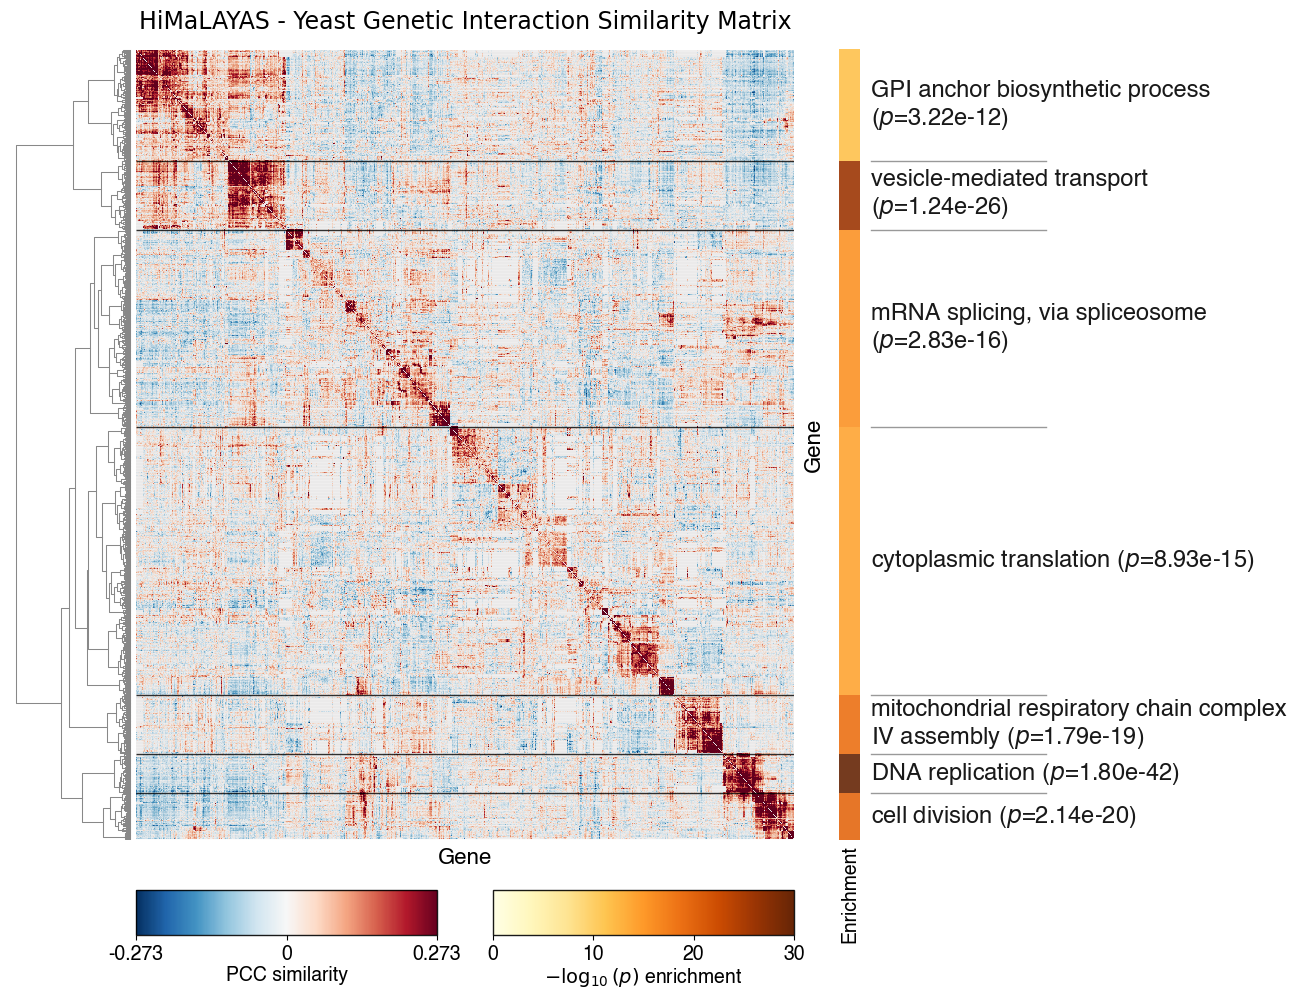

In [6]:
import numpy as np
from matplotlib.colors import Normalize
from himalayas.plot import Plotter

LABEL_COLOR = "black"
BACKGROUND_COLOR = "white"

vals = matrix.values
mask = np.isfinite(vals) & (vals != 0)
vlim = float(np.percentile(np.abs(vals[mask]), 99))

plotter = (
    Plotter(results_sig)
    .set_background(color=BACKGROUND_COLOR)
    .plot_title(
        "HiMaLAYAS - Yeast Genetic Interaction Similarity Matrix",
        color=LABEL_COLOR,
        fontsize=17,
    )
    .plot_dendrogram(
        axes=[0.06, 0.16, 0.09, 0.79],
        data_pad=0.35,
        color="#888888",
        linewidth=0.75,
    )
    .plot_matrix(
        cmap="RdBu_r",
        center=0,
        vmin=-vlim,
        vmax=vlim,
        outer_lw=0,
        figsize=(14, 10),
        subplots_adjust={"left": 0.15, "right": 0.62, "bottom": 0.16, "top": 0.95},
    )
    .plot_matrix_axis_labels(
        xlabel="Gene",
        ylabel="Gene",
        fontsize=16,
        font="Helvetica",
        color=LABEL_COLOR,
        xlabel_pad=6.0,
        ylabel_pad=0.007,
    )
    .plot_cluster_labels(
        term_col="term",
        cluster_col="cluster",
        weight_col="pval",
        label_mode="top_term",
        label_col="term",
        max_words=24,
        wrap_text=True,
        wrap_width=40,
        overflow="wrap",
        font="Helvetica",
        fontsize=17,
        color=LABEL_COLOR,
        skip_unlabeled=False,
        label_fields=("label", "p"),
        omit_words=(),
        boundary_color=LABEL_COLOR,
        boundary_lw=1,
        boundary_alpha=0.8,
        dendro_boundary_alpha=0.0,
        label_text_pad=0.012,
        label_sep_xmin=None,
        label_sep_xmax=0.5,
        label_sep_color=LABEL_COLOR,
        label_sep_lw=1,
        label_sep_alpha=0.4,
        label_gutter_color=BACKGROUND_COLOR,
        axes=[0.62, 0.16, 0.36, 0.79],
    )
    .plot_cluster_bar(
        norm=Normalize(0, 30),
        name="sigbar",
        title="Enrichment",
        width=0.04,
        left_pad=0.06,
        right_pad=0.01,
    )
    .plot_bar_labels(
        font="Helvetica",
        fontsize=14,
        color=LABEL_COLOR,
        pad=4,
        rotation=90,
    )
    .add_colorbar(
        name="matrix",
        cmap="RdBu_r",
        norm=Normalize(-vlim, vlim),
        label="PCC similarity",
        ticks=[-vlim, 0, vlim],
    )
    .add_colorbar(
        name="enrichment",
        cmap="YlOrBr",
        norm=Normalize(0, 30),
        label=r"$-\log_{10}(p)$ enrichment",
        ticks=[0, 10, 20, 30],
    )
    .plot_colorbars(
        ncols=2,
        height=0.045,
        gap=0.05,
        hpad=0.04,
        vpad=0.00,
        fontsize=14,
        font="Helvetica",
        color=LABEL_COLOR,
        border_color=LABEL_COLOR,
        border_width=1.0,
        border_alpha=0.9,
        tick_decimals=3,
    )
)

plotter.save(
    PNG_DIR / "yeast_gi_similarity_matrix.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.02,
)
plotter.show()

## Render Condensed Dendrogram

Summarize the same hierarchy with cluster-level labels and enrichment significance.

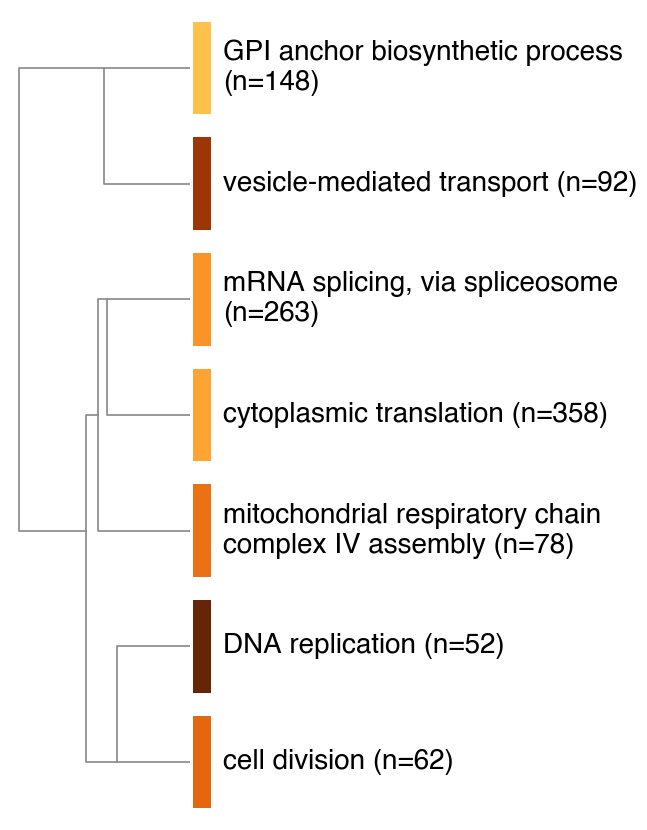

In [7]:
from himalayas.plot import plot_dendrogram_condensed

cluster_dendrogram = plot_dendrogram_condensed(
    results_sig,
    term_col="term",
    cluster_col="cluster",
    weight_col="pval",
    label_mode="top_term",
    label_col="term",
    figsize=(3, 9),
    sigbar_cmap="YlOrBr",
    sigbar_width=0.06,
    sigbar_height=0.8,
    sigbar_min_logp=0.0,
    sigbar_max_logp=30.0,
    font="Helvetica",
    fontsize=20,
    max_words=24,
    wrap_text=True,
    wrap_width=34,
    overflow="ellipsis",
    omit_words=(),
    label_fields=("label", "n"),
    label_color=LABEL_COLOR,
    label_left_pad=0.04,
    dendrogram_color="#888888",
    dendrogram_lw=1.2,
    background_color=BACKGROUND_COLOR,
)
cluster_dendrogram.save(
    PNG_DIR / "yeast_gi_similarity_condensed_dendrogram.png",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.02,
)
cluster_dendrogram.show()